In [1]:
import os
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor, TSFreshRelevantFeatureExtractor
from sktime.datasets import load_from_ucr_tsv_to_dataframe
from sktime.transformations.panel.rocket import Rocket
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from utils import *

In [2]:
# Fungi is interesting dataset (one model much better than the other)
dataset = 'Wine'
X_train, X_test, y_train, y_test = read_dataset(dataset)
X_train, X_test = interpolate_scale(X_train, X_test)

/opt/conda/envs/Base/lib/python3.9/site-packages/sktime/datatypes/_vectorize.py:265: FutureWarning: Creating a Groupby object with a length-1 list-like level parameter will yield indexes as tuples in a future version. To keep indexes as scalars, create Groupby objects with a scalar level parameter instead.
  for name, group in self.X_multiindex.groupby(level=iter_levels, sort=False):
/opt/conda/envs/Base/lib/python3.9/site-packages/sktime/datatypes/_vectorize.py:265: FutureWarning: Creating a Groupby object with a length-1 list-like level parameter will yield indexes as tuples in a future version. To keep indexes as scalars, create Groupby objects with a scalar level parameter instead.
  for name, group in self.X_multiindex.groupby(level=iter_levels, sort=False):
/opt/conda/envs/Base/lib/python3.9/site-packages/sktime/datatypes/_vectorize.py:265: FutureWarning: Creating a Groupby object with a length-1 list-like level parameter will yield indexes as tuples in a future version. To keep 

In [3]:
#def smooth(df, level):
#    import math
#    l = []
#    X_test_ = pd.DataFrame()
#    for i in range(len(df)):
#        series = np.array(df['dim_0'].iloc[i])
#        fltr = np.ones(level) / level
#        series = np.pad(series, (math.floor(level/2), math.floor(level/2)), mode='edge')
#        smoothed_series = np.convolve(series, fltr, mode='valid')
#        l.append(pd.Series(smoothed_series))
#    X_test_["dim_0"] = l
#    return X_test_

#v1 = np.array(smooth(X_train, level=1).iloc[0, 0])
#v2 = np.array(X_train.iloc[0, 0])
#plt.plot(v1)
#plt.plot(v2)
#print(v1-v2)

In [4]:
#def time_warp(x, sigma=0.2, knot=4):
#    from scipy.interpolate import CubicSpline
#    orig_steps = np.arange(x.shape[1])
#    
#    random_warps = np.random.normal(loc=1.0, scale=sigma, size=(x.shape[0], knot+2, x.shape[2]))
#    warp_steps = (np.ones((x.shape[2],1))*(np.linspace(0, x.shape[1]-1., num=knot+2))).T
#    
#    ret = np.zeros_like(x)
#    for i, pat in enumerate(x):
#        for dim in range(x.shape[2]):
#            xi = np.sort(warp_steps[:,dim])
#            yi = np.sort(warp_steps[:,dim] * random_warps[i,:,dim])
#            time_warp = CubicSpline(xi, yi)(orig_steps)
#            scale = (x.shape[1]-1)/time_warp[-1]
#            ret[i,:,dim] = np.interp(orig_steps, np.clip(scale*time_warp, 0, x.shape[1]-1), pat[:,dim]).T
#    return ret
#
#def scaling(x, sigma=0.1):
#    # https://arxiv.org/pdf/1706.00527.pdf
#    factor = np.random.normal(loc=1., scale=sigma, size=(x.shape[0],x.shape[2]))
#    return np.multiply(x, factor[:,np.newaxis,:])
#
#def permutation(x, max_segments=8, seg_mode="equal"):
#    orig_steps = np.arange(x.shape[1])
#    
#    num_segs = np.random.randint(1, max_segments, size=(x.shape[0]))
#    
#    ret = np.zeros_like(x)
#    for i, pat in enumerate(x):
#        if num_segs[i] > 1:
#            if seg_mode == "random":
#                split_points = np.random.choice(x.shape[1]-2, num_segs[i]-1, replace=False)
#                split_points.sort()
#                splits = np.split(orig_steps, split_points)
#            else:
#                splits = np.array_split(orig_steps, num_segs[i])
#            warp = np.concatenate(np.random.permutation(splits)).ravel()
#            ret[i] = pat[warp]
#        else:
#            ret[i] = pat
#    return ret

In [5]:
#x = np.arange(0, 12, step=0.1)
#
#v = np.sin(x)
#plt.plot(v)
#z = v.reshape(1, len(v),1)
#z1 = time_warp(z, sigma=0.2)
#plt.plot(z1[0, :, 0])

In [6]:
#z1[0, :, 0].shape

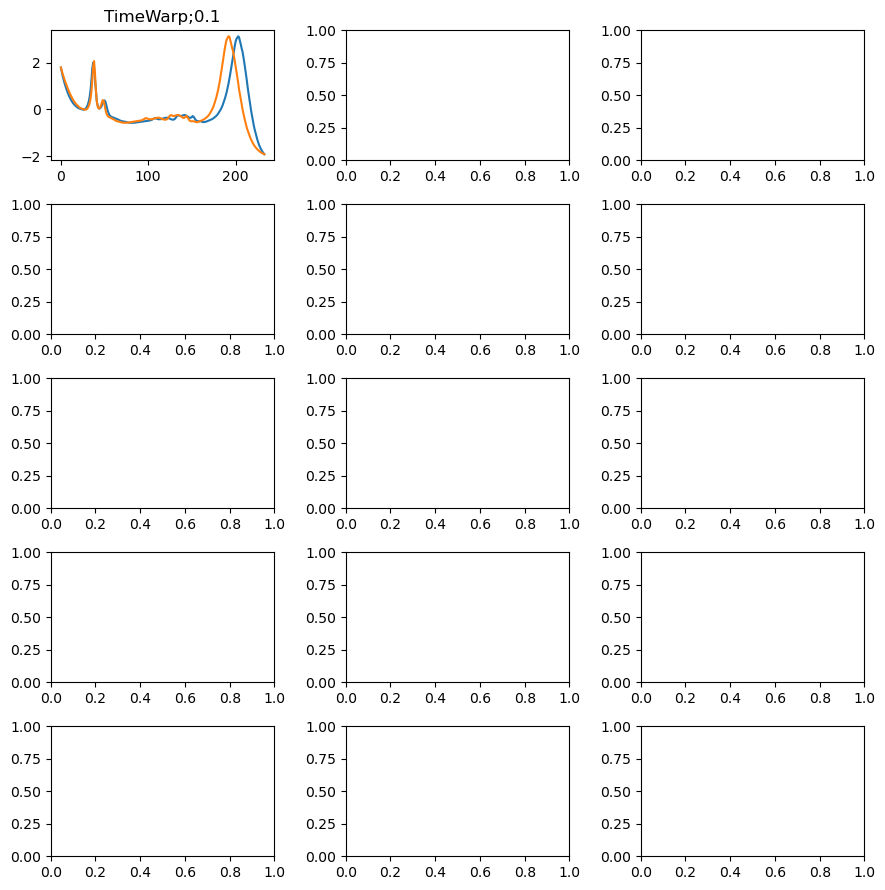

In [7]:
fig, axs = plt.subplots(5, 3, figsize=(9, 9))

# List of transformations
transformations = [
    #'RandomWalk;0.07',
    #'WhiteNoise;0.2',
    #'Constant;1.0',
    #'Resample;0.9',
    #'Scale;-0.5',
    #'Spike;5',
    #'Shift;5',
    #'WindowSlice;0.7',
    #'MagnitudeWarp;0.2',
    #'Permutation;3',
    #'DataLoss;95',
    #'Quantize;6',
    'TimeWarp;0.1'
]

#transformations = ['RandomWalk;0.07']

# Loop through the transformations and apply them
for i, transform in enumerate(transformations):
    transformation = transformation_factory(transform)
    row = i // 3  # Calculate the row index
    col = i % 3   # Calculate the column index
    
    # Plot the transformed and original data
    axs[row, col].plot(list(transformation(X_train).iloc[0, 0]))
    axs[row, col].plot(list(X_train.iloc[0, 0]))
    axs[row, col].set_title(transform)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig(f'figures/transformation_examples.pdf', bbox_inches='tight', pad_inches=0)

In [8]:
#dfgdg=erge

In [9]:
#def quantize_values(values, n_levels):
#    if n_levels <= 0:
#        raise ValueError("Number of levels must be greater than 0")
#    # Define the quantization levels
#    min_val, max_val = min(values), max(values)
#    levels = np.linspace(min_val, max_val, n_levels)
#    # Quantize each value
#    quantized_values = [min(levels, key=lambda x: abs(x - value)) for value in values]
#    return np.array(quantized_values)
#
#def quantize(df, level):
#    l = []
#    X_test_ = pd.DataFrame()
#    for i in range(len(df)):
#        imp = Imputer(method='linear')
#        series = df['dim_0'].iloc[i]
#        seriesq = quantize_values(np.array(series), 16)
#        l.append(pd.Series(seriesq))
#    X_test_["dim_0"] = l
#    return X_test_

In [10]:
#transform = 'MagnitudeWarp;1'
#transformation = transformation_factory(transform)
#print(transformation)
#v1 = np.array(list(transformation(X_train.head(1)).iloc[0, 0]))
#v2 = np.array(list(X_train.iloc[0, 0]))
#plt.plot(v1)
#plt.plot(v2)

In [11]:
from utils import *

In [12]:
X_train, X_test, y_train, y_test = read_dataset('BME')
X_train, X_test = interpolate_scale(X_train, X_test)

/opt/conda/envs/Base/lib/python3.9/site-packages/sktime/datatypes/_vectorize.py:265: FutureWarning: Creating a Groupby object with a length-1 list-like level parameter will yield indexes as tuples in a future version. To keep indexes as scalars, create Groupby objects with a scalar level parameter instead.
  for name, group in self.X_multiindex.groupby(level=iter_levels, sort=False):
/opt/conda/envs/Base/lib/python3.9/site-packages/sktime/datatypes/_vectorize.py:265: FutureWarning: Creating a Groupby object with a length-1 list-like level parameter will yield indexes as tuples in a future version. To keep indexes as scalars, create Groupby objects with a scalar level parameter instead.
  for name, group in self.X_multiindex.groupby(level=iter_levels, sort=False):
/opt/conda/envs/Base/lib/python3.9/site-packages/sktime/datatypes/_vectorize.py:265: FutureWarning: Creating a Groupby object with a length-1 list-like level parameter will yield indexes as tuples in a future version. To keep 

/home/jovyan/work/utils.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  warp = np.concatenate(np.random.permutation(splits)).ravel()
<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/jovyan/work/utils.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  warp = np.concatenate(np.random.permu

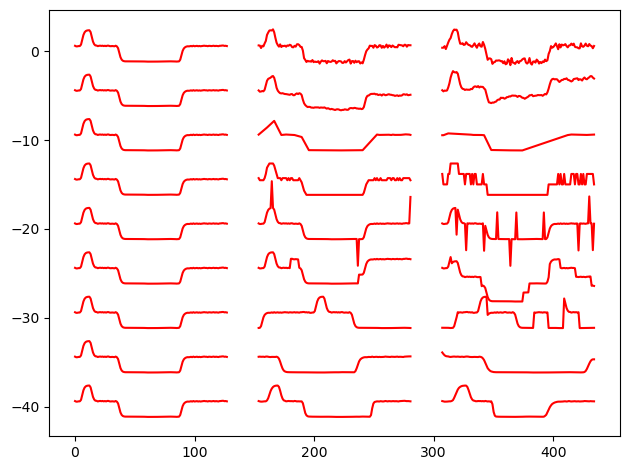

In [17]:
#fig, axs = plt.subplots(4, 3, figsize=(9, 9))


transformation_groups = [
    ('None', 'WhiteNoise;0.1', 'WhiteNoise;0.2'),
    ('None', 'RandomWalk;0.05', 'RandomWalk;0.1'),
    ('None', 'DataLoss;80', 'DataLoss;90'),
    ('None', 'Quantize;16', 'Quantize;4'),
    ('None', 'Spike;3', 'Spike;10'),
    ('None', 'Shift;3', 'Shift;10'),
    ('None', 'Permutation;3', 'Permutation;10'),
    ('None', 'WindowSlice;0.8', 'WindowSlice;0.6'),
    ('None', 'TimeWarp;0.05', 'TimeWarp;0.1'),
    #'Constant;1.0',
    #'Resample;0.9',
    #'Scale;-0.5',
    #'Spike;5',
    #'Shift;5',
    #'WindowSlice;0.7',
    #'MagnitudeWarp;0.2',
    #'Permutation;3',
    #'DataLoss;95',
    #'Quantize;6'
]

for j, transformations in enumerate(transformation_groups):
    for i, transform in enumerate(transformations):
        transformation = transformation_factory(transform)
        ts = np.array(list(transformation(X_train).iloc[0, 0])) - j*5
        xs = np.array(range(len(ts)))
        plt.plot(1.2* i*len(xs) + xs, ts, color='red')


# Adjust layout and save the figure
plt.tight_layout()
#plt.savefig(f'figures/transformation_examples.pdf', bbox_inches='tight', pad_inches=0)

/home/jovyan/work/utils.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  warp = np.concatenate(np.random.permutation(splits)).ravel()
<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/jovyan/work/utils.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  warp = np.concatenate(np.random.permu

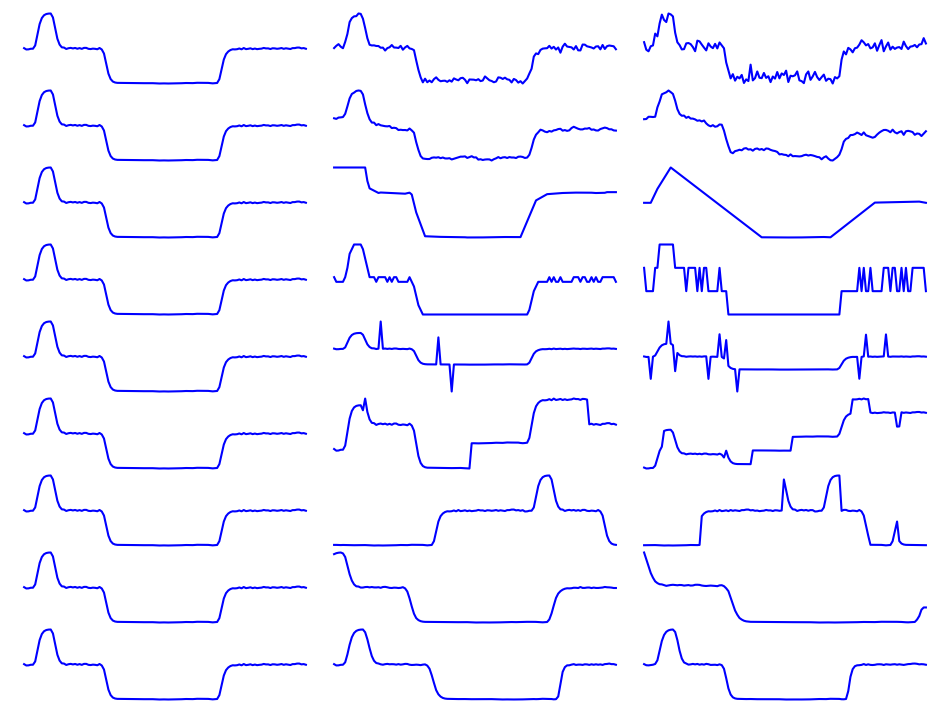

In [18]:
import matplotlib.pyplot as plt

# Create a 3x4 subplot grid
fig, axs = plt.subplots(9, 3, figsize=(12, 9))

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0, hspace=0)

# Iterate over each subplot and plot a line
for i, transformations in enumerate(transformation_groups):
    for j, transform in enumerate(transformations):
        ax = axs[i, j]
        #ax.plot(np.random.randn(100), np.random.randn(100), color='blue')
        #ax.set_xlim(0, 1)
        #ax.set_ylim(0, 1)

        transformation = transformation_factory(transform)
        ts = np.array(list(transformation(X_train).iloc[0, 0]))
        #xs = np.array(range(len(ts)))
        ax.plot(ts, color='blue')
        ax.axis('off')  # Turn off axis
        #ax.grid()

plt.savefig(f'figures/transformation_examples.pdf', bbox_inches='tight', pad_inches=0)